In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

In [2]:
df = pd.read_csv('consolidated_contracts.csv')

In [3]:
# Convert date strings to date-time objects
df['date'] = pd.to_datetime(df['date'])

In [4]:
contract_lengths = df['announcement'].str.len()

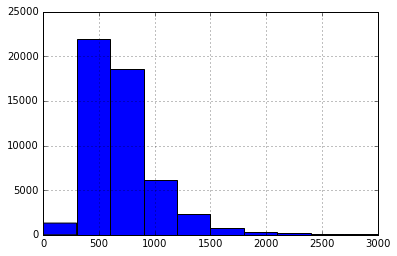

In [5]:
# Setting a range here because there is one extremely high value (40000+) that throws the graph off
contract_lengths.hist(range=[0, 3000], bins=10)

In [6]:
# Find the overly length announcements
# Find announcements that mention "contracting activity" multiple times (indicates multiple entires usually)
suspect_announcements = df[(df['announcement'].str.len() > 2500) & 
                          (df['announcement'].str.count('contracting activity', flags=re.IGNORECASE) > 1)]

In [7]:
print(suspect_announcements)

            date                                       announcement
27848 2006-08-09  CONTRACTS NAVY Harris Corp., RF Communications...
27865 2006-08-11  CONTRACTS AIR FORCE Rockwell Collins Inc., Ced...
27866 2006-08-14  CONTRACTS AIR FORCE Aerospace Testing Alliance...
27867 2006-08-15  CONTRACTS ARMY General Dynamics, St. Petersbur...
27868 2006-08-16  CONTRACTS MISSILE DEFENSE AGENCY Raytheon Miss...
27869 2006-08-18  CONTRACTS DEFENSE LOGISTICS AGENCY Science App...
27870 2006-08-21  CONTRACTS DEFENSE INFORMATION SYSTEMS AGENCY (...
27871 2006-09-06  CONTRACTS ARMY GM GDLS Defense Group L.L.C. (J...
27872 2006-09-06  Spindler Construction Corp.*, Logan, Utah, was...
27873 2006-09-07  CONTRACTS DEFENSE LOGISTICS AGENCY Valero Mark...
27874 2006-09-08  Lear Siegler Logistics International Inc., Gai...
27880 2006-09-11  GM GDLS Defense Group L.L.C. (Joint Venture), ...
27881 2006-09-13  CONTRACTS NAVY Raytheon Co., Tucson, Ariz. is ...
27882 2006-09-14  CONTRACTS ARMY Raytheon Co., M

In [8]:
# Export to CSV for manual editing and splitting of long announcements that are probably repeated
suspect_announcements.to_csv('suspect_announcements.csv')

In [9]:
# Re-import CSV with "BREAK" inserted between announcements that are on the same line
updated_entries = pd.read_csv('suspect_announcements_broken_up.csv', index_col='index')

In [10]:
# Update the original data frame with the new, manually edited entries
df['announcement'].update(updated_entries['announcement'])

In [11]:
# Make sure the update worked
df['announcement'].str.count('BREAK').sum()

544

In [12]:
# Split upon the occurences of 'BREAK' (this will expand each row into multiple columns that need to be flattened)
df['announcement'] = df['announcement'].str.split('BREAK', expand=False)

In [13]:
grouped = df.groupby(df['date'])

In [14]:
aggregated = grouped.aggregate(lambda x: list(x))

In [15]:
# Concat the lists since some have multiple values while others are empty
aggregated['announcement'] = aggregated['announcement'].apply(
    lambda lists: [item for sublist in lists for item in sublist])

In [18]:
# Each date should not have only one row, while the next column is a list for all releases from that date
print(aggregated)

                                                 announcement
date                                                         
1994-10-07  [Pioneer Aluminum,* Los Angeles, California, w...
1994-10-11  [Hyster Company, Portland, Oregon, is being aw...
1994-10-12  [FSEC, Inc., Pasadena, California, is being aw...
1994-10-14  [The MITRE Corporation, McLean, Virginia, is b...
1994-10-20  [Lockheed Aeromod Center, Incorporated, Greenv...
1994-10-21  [Bell Helicopter Textron Incorporated, Ft. Wor...
1994-10-24  [Electrospace Systems, Inc., Richardson, Texas...
1994-10-25  [Southeastern Computer Consultants, Inc., (SCC...
1994-10-26  [Hughes Missile Systems Company, Tucson, Arizo...
1994-10-27  [Burlington Menswear, New York, New York, was ...
1994-10-28  [Lockheed Missiles & Space Company, Inc., Sunn...
1994-10-31  [General Dynamics Corporation, Electric Boat D...
1994-11-02  [Booz-Allen and Hamilton, Inc., McLean, Virgin...
1994-11-03  [Newport News Shipbuilding and Drydock Company...
1994-11-

In [19]:
# Export to CSV
aggregated.to_csv('consolidated_contracts_split.csv')